In [0]:
import numpy as np
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [0]:
class Policy(nn.Module):
  def __init__(self,input_shape, action_space):
    super(Policy, self).__init__()
    self.seed = torch.manual_seed(42)
    self.pi = nn.Sequential(
                              nn.Linear(input_shape,64),
                              nn.ReLU(),
                              nn.Linear(64, action_space),
                              nn.Softmax(dim = -1)
                            )
    
  def forward(self, x):
    x = self.pi(x)
    dist = Categorical(x)
    action = dist.sample()
    logprob = dist.log_prob(action)
    return action, logprob, dist

In [0]:
def calc_discounted_rewards(rewards, mask, gamma = 0.975):
  R = 0
  discounted = []
  
  for idx in reversed(range(len(rewards))):
    R = rewards[idx]+R * gamma * mask[idx]
    discounted.insert(0,R)
  return discounted

In [0]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, masks):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids], actions[rand_ids], log_probs[rand_ids], returns[rand_ids], masks[rand_ids]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, masks, eps_clip=0.2):
    losses = []

    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, mask  in ppo_iter(mini_batch_size, states, actions, log_probs, returns, masks):
          #print(state.shape)
          _, _, dist = pi(state)
          #entropy = dist.entropy().mean()
          new_log_probs = dist.log_prob(action)

          advantage = torch.Tensor(calc_discounted_rewards(return_, mask))

          ratio = torch.exp(new_log_probs - old_log_probs)
          surr = ratio * advantage

          clip = torch.clamp(ratio, 1.0 - eps_clip, 1.0 + eps_clip) 

          loss  = - (torch.min(surr, clip*advantage).mean()) #* entropy


          optimizer.zero_grad()
          loss.backward(retain_graph=True) 
          optimizer.step()
          losses.append(loss.detach().numpy())
     
    return np.array(losses).mean()


Rewards: 25.0 | Loss: nan

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rewards: 30.0 | Loss: -10.453255653381348

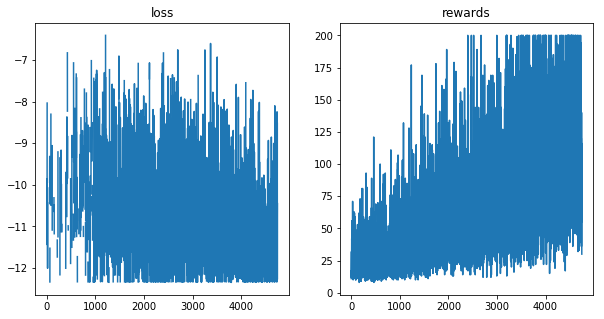

In [31]:
env = gym.make("CartPole-v0") 
input_shape = env.observation_space.shape[0]
action_space = env.action_space.n

frame_idx = 0
max_frames = 300000

pi = Policy(input_shape=input_shape, action_space= action_space)
optimizer = optim.Adam(pi.parameters(), lr = 0.0001)

total_rewards = []
total_loss = []

max_steps = 200


while frame_idx < max_frames:

  log_probs = []
  actions = []
  states = []
  rewards = []
  masks = []
  done = False
  state = env.reset()
  rewards_plot = 0
  
  while not done:

    state_v = torch.FloatTensor(state).unsqueeze(0)
    states.append(state_v)
    action, log_prob, _ = pi(state_v)
    actions.append(action)
    new_state, reward, done, _ = env.step(action.item())
    
    log_probs.append(log_prob)
    rewards.append(reward)
    masks.append(1-done)
    
    state = new_state
    rewards_plot += reward
    frame_idx += 1
    
    if done:
      break


  states = torch.cat(states)
  actions = torch.cat(actions)
  log_probs = torch.cat(log_probs).detach()
  rewards_ = torch.Tensor(rewards)
  masks = torch.Tensor(masks)
  
  #print("states ", states.shape)
  #print(states,"\n")
  #print("actions ", actions.shape)
  #print("log probs", log_probs.shape)
  #print("rewards ", rewards_.shape)
  #print("mask ", masks.shape)
  
  loss = ppo_update(ppo_epochs = 4, mini_batch_size = 30, states = states, actions = actions, log_probs = log_probs, returns = rewards_, masks = masks)

  total_rewards.append(rewards_plot)
  total_loss.append(loss)
  print("\rRewards: {} | Loss: {}".format(rewards_plot, loss), end = "", flush = True)
  
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("loss")
plt.plot(total_loss)
plt.subplot(1,2,2)
plt.title("rewards")
plt.plot(total_rewards)
plt.show()